# Mall Customer Segmentation Clustering
### Discovering the Hidden Chest

Author : Wong Zhao Wu, Bryan

# Modelling Objective
- Achieve customer segmentation using unsupervised machine learning algorithms.
- Identify the target customers and devise a marketing strategy to boost the growth of the mall supermarket.

## Keywords
- Unsupervised Learning
- K-Means Clustering
- Silhouette Analysis
- Hierarchical Clustering
- Spectral Clustering
- Clusters Interpretation

In [5]:
from typing import Sequence, Tuple
from itertools import combinations, chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Reading Dataset
The [Mall Customer](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python) dataset is a simple & clean example with 4 attributes and 200 records. The ultimate task of this dataset is to perform clustering and devise a feasible strategy to increase the mall's profit.
## Data Dictionary
| Columns | Descriptions |
| :--     | :--          |
| CustomerId | Unique ID assigned to the customer |
| Gender | Gender of the customer |
| Age | Age of the customer |
| Annual Income (k$) | Annual Income of the customer |
| Spending Score (1-100) | Score assigned by the mall based on customer behavior and spending nature |


In [6]:
cust_df = pd.read_csv("Mall_Customers.csv").rename(columns={'Genre':'Gender'}) #Rename to Gender for Genre Column
cust_df.Gender = cust_df.Gender.astype('category') # Turns Gender to category dtype
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              200 non-null    int64   
 1   Gender                  200 non-null    category
 2   Age                     200 non-null    int64   
 3   Annual Income (k$)      200 non-null    int64   
 4   Spending Score (1-100)  200 non-null    int64   
dtypes: category(1), int64(4)
memory usage: 6.7 KB


In [7]:
cust_df.describe(include='all')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


# EDA
A good data science project starts from understanding your data. With that, I will perform some basic visualisation to spot some trends and errors in my dataset.

## Pairplot
Since our feature space is not extremely large, we can afford to plot out a **Pairplot** to visualise the distribution of datapoints, categorised by the gender with the hope of answering the following questions:

1. Is there an **identifiable cluster** by glancing through the datapoints?
2. Is there a **significant difference** of the Spending Behaviour **across different gender**?
3. Is there a need to **remove/create certain features** to reduce ambiguity for the clustering?
 

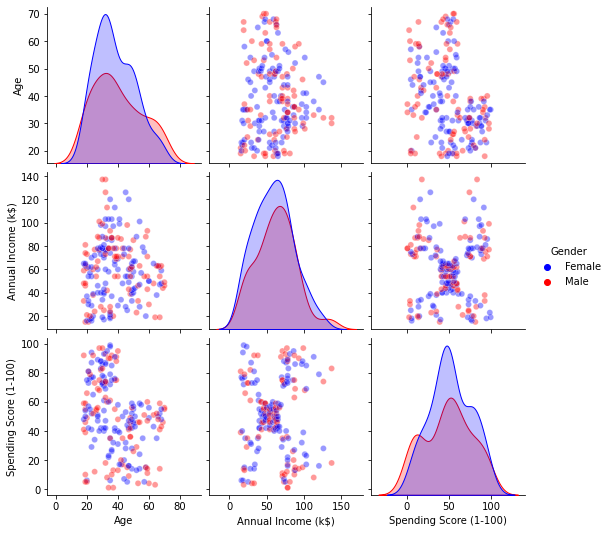

In [8]:
sns.pairplot(cust_df.drop(columns='CustomerID'), hue = 'Gender', palette=['b', 'r'], plot_kws=dict(alpha=0.4))
plt.show()

**Observations:**

1. By just comparing `Annual Income (k$)` and `Spending Score (1-100)`, there **seems to be 5 identifiable clusters**.
2. Female seems to have higher mean `Spending Score (1-100)` as compared to male. However, by observing the scatterplots, the distribution of male and female datapoints seems to be **randomly scattered across different measures**. Hence, it is arguable that there *might not be a significant different of spending habits across Male and Female*.
3. There are **no identifiable clusters wrt to `Age` attribute**, which might lead to ambiguity for the clustering algorithm. However, further analysis is required to unveil the relationship of `Age` with other attributes.

## Correlation Plot
From the correlation plot, there seems to be weak linear relationship observed between `Age` and `Spending Score (1-100)`, implying that there might be something going on for `Age` that we have yet to understand. As for the rest of features, the sample correlation value is relatively small and close to zero.

Since our objective is to perform clustering, which is not badly affected by collinearity/correlations, we can just leave all attributes as it is and move on to the next step.

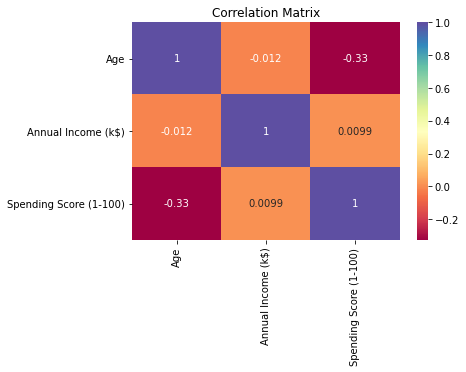

In [9]:
sns.heatmap(cust_df.drop(columns='CustomerID').corr(), annot= True, cmap='Spectral')
plt.title("Correlation Matrix")
plt.show()

# Data Preprocessing
There are a few preprocessing steps that we shall perform, before proceeding to the actual clutering, which include:

1. **Dropping `CustomerID`** column *since it does not review any useful information*.
2. **Standard Scaling** of the datapoints *to ensure all attributes are in the same scale*.
3. Create **Dichotomous Variable** for `Gender` column *since our model cannot interpret categorical values as it is*.

## 1. Dropping CustomerID

In [10]:
cust_df.drop(columns='CustomerID', inplace=True)

## 2. Standard Scaling

In [11]:
scaler = StandardScaler()
cust_df_scale = cust_df.copy()
cust_df_scale[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(cust_df_scale[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
cust_df_scale.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,-1.424569,-1.738999,-0.434801
1,Male,-1.281035,-1.738999,1.195704
2,Female,-1.352802,-1.700830,-1.715913
3,Female,-1.137502,-1.700830,1.040418
4,Female,-0.563369,-1.662660,-0.395980


## 3. Dichotomous Variable

In [12]:
cust_df_onehot = pd.get_dummies(cust_df_scale, drop_first=True)
cust_df_onehot.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


# Clustering
After we are done with our data, we will then proceed with the main dish of the day, performing some clustering with some commonly used clustering algorithms.

I will tryout algorithms from different family and different approach to compare and contrast and find out the algorithm that can give us the most distinguishable clustering with an interpretable result.

## K-Means Clustering (Centroid-based)
K-Means Clustering is one of the most famous clustering algorithms that assign clusters based on the distance towards the cluster centroids. I will start by defining a utility function that will return fitted kmean model and some other metrics to save us a few line of code during parameter tuning.

In [13]:
def calculate_k_mean(n_cluster: int, X: Sequence)-> Tuple[float, Sequence, Sequence, sklearn.cluster._kmeans.KMeans]:
    '''
    General Function to returns commonly used metrics for K-Means Clustering and the fitted instance
    '''
    kmean = KMeans(n_clusters = n_cluster, random_state=24)
    cluster_labels = kmean.fit_predict(X)
    return kmean.inertia_, cluster_labels, kmean.cluster_centers_, kmean


### Choosing Number of $k$
I will be using two main approach to evaluate the quality of the clusters formed with K-Means of different $k$ values.

In [14]:
log = [] 
silhoettes = True
k_range = range(2,9) # Range of k values

for k in k_range:
    inertia, cluster_labels, _, _ = calculate_k_mean(k, cust_df_onehot) # Fitting the model
    if silhoettes: # Generate Silhoettes Score
        silhoettes_avg = silhouette_score(cust_df_onehot, cluster_labels)
        log.append([k, inertia, silhoettes_avg])
        continue
    log.append([k, inertia])

### Elbow Method (Inertia)
Elbow Method is used to identify $k$ when the **Inertia Dropped Significantly** as compared to inertia before.


$$ \text{Inertia} = \sum^m_{i=1}||x^{(i)}-\mu_{c^{(i)}}||^2_2 $$

- $m$ : Number of Datapoints
- $x^{(i)}$ : i-th Datapoints
- $\mu_{c^{(i)}}$ : Cluster Centroids for i-th Datapoints

> Inertia Measure the Sum of Squared Distance of each datapoints to its assigned cluster centroids.

**Remarks:**
- With $k$ increase, the inertia will decrease. This is because with more clusters being formed, each datapoints will be closer to its centroids. However, this come at the cost of interpretability of the cluster formed with high number of $k$
- The "Elbow" might not be visible if the clustering is ambiguous.

### Silhouette Analysis
Silhouette Coefficient $\in [-1,1]$ is a convenient metric to **Quantify the Distinguishability of the Cluster Formed** with 1 denote a highly packed cluster and 0 denote an overlapping cluster.

$$ \text{Silhouette Coefficient}, s(o) = \frac{b(o) - a(o)}{max(a(o), b(o))} $$
<p align='center'>
    <img src="https://2.bp.blogspot.com/-dQi4lSpbbnw/Wpr7iFzrjFI/AAAAAAAACps/qliCgVQ1gW4Jrri_UT_7d9JKI_LXd0n8wCLcBGAs/s1600/ssi-formula.png" style="background: #fff;">
</p>

- $s(o)$ : Silhouette Coefficient of datapoints $o$
- $a^{(i)}$ : Average Distance to other datapoints of the Assigned Cluster Centroids
- $b^{(i)}$ : Average Distance to Nearest Cluster Centroids


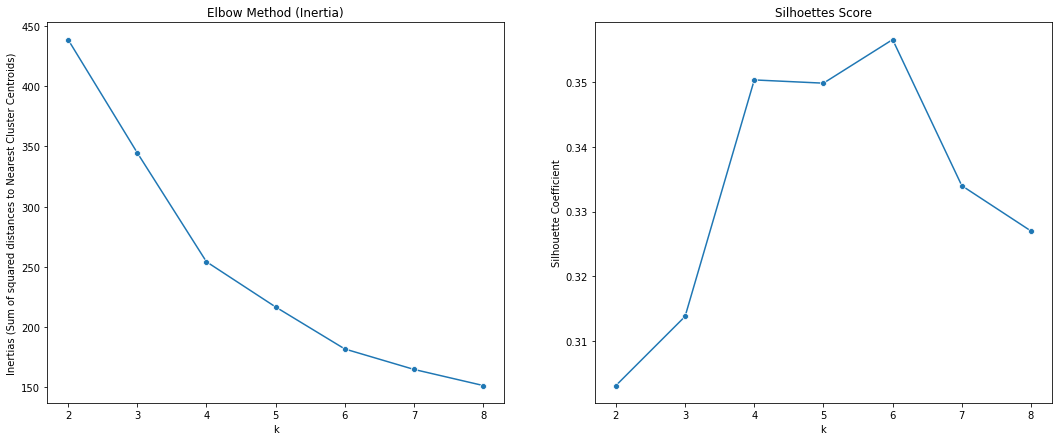

In [26]:
plot_df = pd.DataFrame(
    log, columns = [
        'k', 'Inertias (Sum of squared distances to Nearest Cluster Centroids)', 'Silhouette Coefficient'
        ]
    )
fig, axes = plt.subplots(1,2, figsize=(18,7))
sns.lineplot(
    x='k', y='Inertias (Sum of squared distances to Nearest Cluster Centroids)', 
    data = plot_df, marker= 'o', ax = axes[0])
axes[0].set_title("Elbow Method (Inertia)")
sns.lineplot(x='k', y='Silhouette Coefficient', data=plot_df, marker='o', ax = axes[1])
axes[1].set_title("Silhoettes Score")
plt.show()

**Observations:**

- Through the **Elbow Method**, choosing the number of **$k$ is quite ambiguous** as the Inertia seems to decrease uniformly when $k$ increase.

- However, through analysis of the average **Silhouettes Scores**, we noticed the **Silhouettes score max out at $k \in [4,6]$ with peak at $k=6$**.

Hence, **$k = 4,5,6$ seems to be a good candidates** for the number of clusters generated, let us perform a more comprehensive **Silhouettes Analysis** and visualisation of the clusters through **PCA** (*as we cannot straight away plot a chart with 4-Dimension*).

### Silhouette Analysis

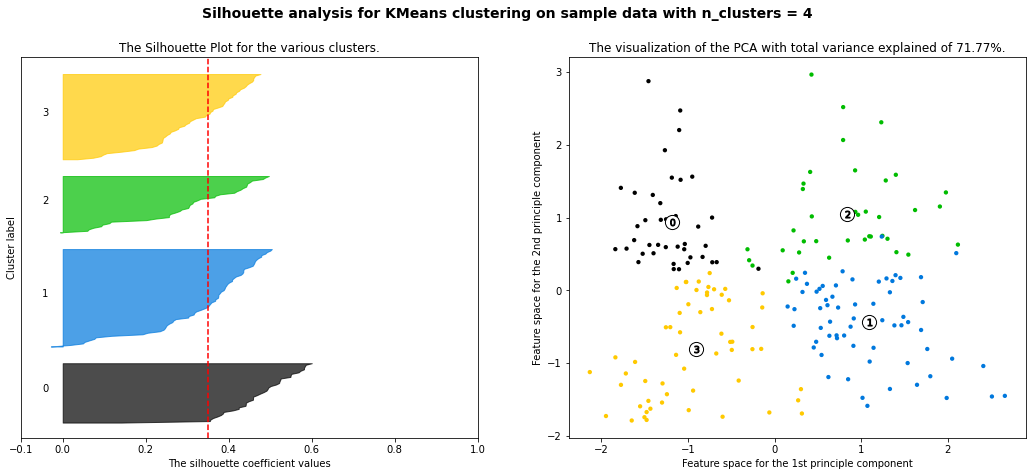

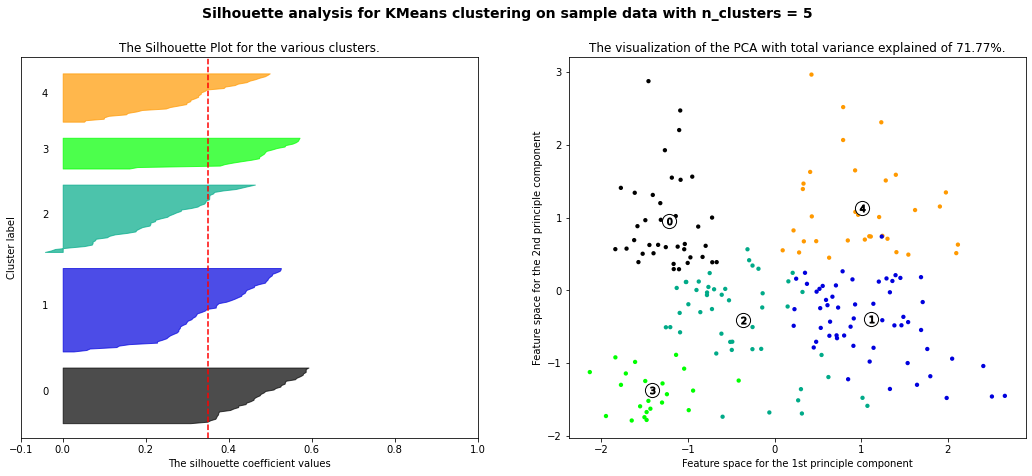

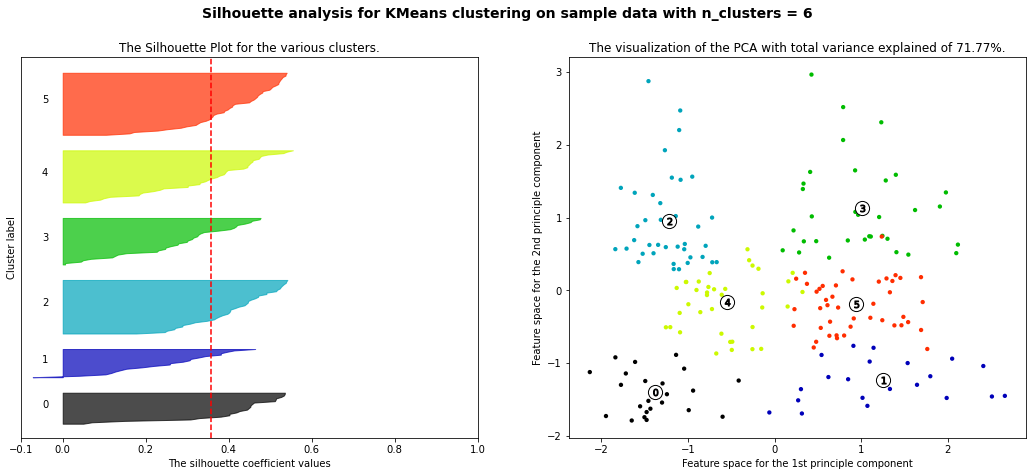

In [16]:
def silhouette_analysis_with_pca(n_clusters : int,  X: Sequence):
    '''
    Perform Silhoette Analysis and Visualising the clusters generated using PCA

    Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    
    # Perform K-Mean Clustering
    _, cluster_labels, cluster_centroids, kmean = calculate_k_mean(n_clusters, X)

    # Compute Individual Silhoette Score
    silhoettes_avg = silhouette_score(X, cluster_labels)

    # Compute Average Silhoette Score
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ################################### Silhouette Plot #############################################
 
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(cust_df) + (n_clusters + 1) * 10])
    y_lower = 10

    # Assign colours for different cluster
    for i in range(n_clusters):
         # Aggregate the silhouette scores for samples belonging to
         # cluster i, and sort them
         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
         ith_cluster_silhouette_values.sort()
         size_cluster_i = ith_cluster_silhouette_values.shape[0]
         y_upper = y_lower + size_cluster_i
         color = cm.nipy_spectral(float(i) / n_clusters)
         ax1.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         # Compute the new y_lower for next plot
         y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The Silhouette Plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhoettes_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ################################### PCA Plot #############################################
 
    # Compute PCA with only First 2 Number of Component
    pca2 = PCA(n_components=2)
    sample_pca2 = pca2.fit_transform(X)

    # Plotting the PCA graph
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sample_pca2[:,0], sample_pca2[:,1], marker='.', s=75, lw=0, alpha=1,
            c=colors, edgecolor='k')

    # Labeling the clusters
    centers = cluster_centroids.dot(pca2.components_.T) # Calculate New Cluster Positions after PCA

    # Labelling each cluster centroids
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                 c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the PCA with total variance explained of {:.2f}%.".format(pca2.explained_variance_ratio_.sum()*100))
    ax2.set_xlabel("Feature space for the 1st principle component")
    ax2.set_ylabel("Feature space for the 2nd principle component")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

for i, k in enumerate(range(4,7)): # Analyse k = (4,5,6)
    silhouette_analysis_with_pca(n_clusters = k, X = cust_df_onehot)
    plt.show()

By visualising the cluster formed as well as the silhouette analysis, the following are the observations for each $k \in \{4,5,6\}$:
- $k=4$

    The clusters formed are quite balanced, by seperating the datapoints into 4 different region without much overlapping.
    
- $k=5$

    Cluster formed for 2nd class is quite inconsistent and overlapping as shown in the steep in silhouette analysis as well as the PCA scatterplot.

- $k=6$

    1st Class seems to be slightly overlapping with 0th Class and 5th Classs. However, the clustering seems to be able to capture the general trend quite well.

Hence, from the observations gathered, the **plausible values of $k$ is between $4 \text{ or } 6$** when we perform clustering with all 4 features. Before we proceed to the next algorithm let us explore further on how Feature Selection can help to improve the quality of clustering.

## Unsupervised Feature Selections
To examine which combinations of features can generate more quality clustering, one method is to perform clustering with different subset of features. The aim of this is to maximise the Silhoette Score and generate high quality and interpretable clusters. I will be using the same Elbow Method and Silhoette Score to evaluate the quality of the clusters formed.

In [17]:
features_sets = chain(combinations(cust_df_onehot.columns,3), combinations(cust_df_onehot.columns,4)) # Different Subset of attributes
logs = []
k_range = range(2,10) # Range of k values
for features in features_sets:
    for k in k_range:
        inertia, cluster_labels, _, _ = calculate_k_mean(k, cust_df_onehot[list(features)])
        silhoettes_avg = silhouette_score(cust_df_onehot, cluster_labels)
        logs.append([features, k, inertia, silhoettes_avg])

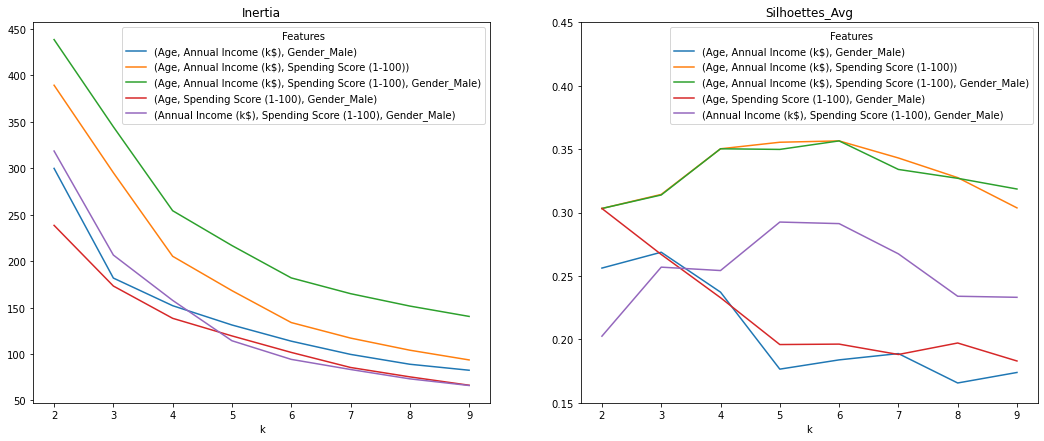

In [18]:
records_df = pd.DataFrame(logs, columns=['Features', 'k', 'Inertia', 'Silhoettes_Avg']).set_index("Features") # Saving history to dataframe
silhoettes_pivot = records_df.pivot_table(values = 'Silhoettes_Avg', index='k', columns='Features') 
inertia_pivot = records_df.pivot_table(values = 'Inertia', index='k', columns='Features')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 7))

inertia_pivot.plot(ax = ax1)
ax1.set_title("Elbow Method (Inertia)")

silhoettes_pivot.plot(ax=ax2)
ax2.set_title("Silhoettes Score")
ax2.set_ylim(0.15, 0.45) # Set y lim to make legend more visible

plt.show()

**Observations:**

From the Inertia Plot and Silhoettes Plot generated, we can argue that **Removing Gender_Male as a clustering feature has close to no effect to the clusters formed** as shown by the Silhoettes_avg of having almost similar shape. This is corroborated with the **ambiguous datapoints** as shown in the Pairplot earlier in EDA.

Hence, for the sake of visualisation, I've decided to **Remove Gender_Male from my feature set**.

Before we move straight away into Clusters Interpretation, let us try out multiple clustering algorithms and compare the clusters formed than over-relying on the public's favourite K-Means.

### Dropping Gender Column

In [19]:
# Dropping Gender from my features
cust_df_scale.drop(columns="Gender", inplace=True)

## Aggrolomative Clustering (Hierarchical)

As many sources of data are generated from a process defined by an underlying hierarchy or taxonomy, we can argue that there is a potential hierarchical relationship for our data. Let us explore this notion further by plotting the Dendogram and Evaluate the Clusters Formed.

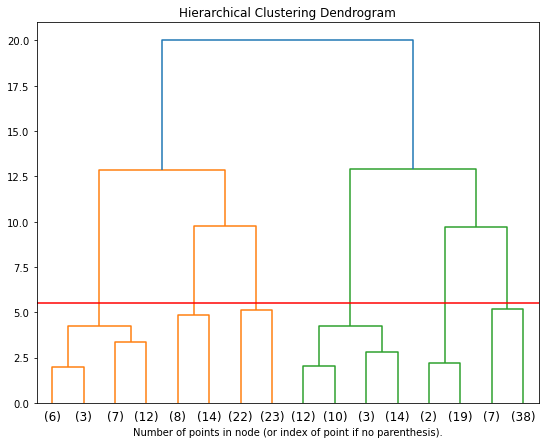

In [27]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(cust_df_scale)

plt.figure(figsize = (9,7))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agg_cluster, truncate_mode='level', p=3)
plt.hlines(5.5, 0, 300, colors = 'r') # Plotting the clutering line with optimal seperation
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Observations**

From the dendrogram generated, the reasonable number of cluster would be $k=6$ since moving forward, the taller the edge makes notion of merging the clusters more dodgy.

Hence, let us visualise the cluster formed through the scatterplots for all 3 features.

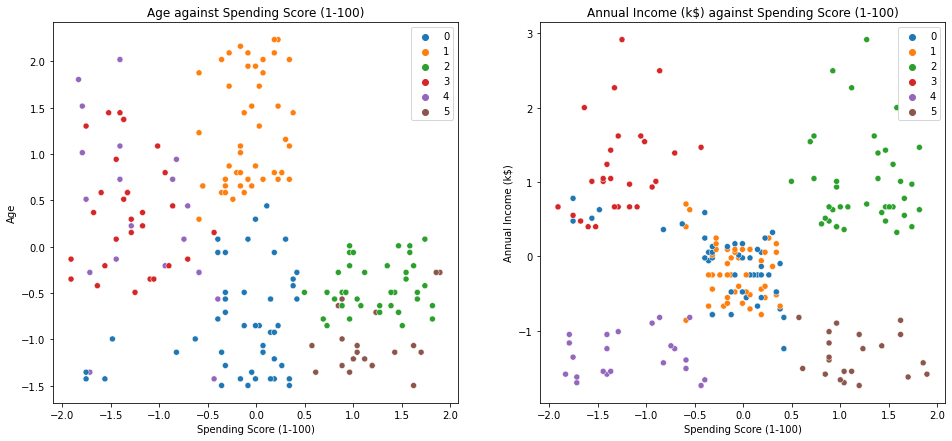

In [28]:
# Setting Number of Cluster to 6
agg_cluster_6 = AgglomerativeClustering(n_clusters=6)

agg_labels = agg_cluster_6.fit_predict(cust_df_scale)


# Plotting the PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,7))
# Plotting Age against Spending Score (1-100)
sns.scatterplot(x = 'Spending Score (1-100)', y='Age', hue = agg_labels, palette = 'tab10', data = cust_df_scale, ax = ax1)
ax1.set_title("Age against Spending Score (1-100)")

# Plotting Annual Income (k$) against Spending Score (1-100)
sns.scatterplot(x = 'Spending Score (1-100)', y='Annual Income (k$)', hue = agg_labels, palette = 'tab10', data = cust_df_scale, ax = ax2)
ax2.set_title("Annual Income (k$) against Spending Score (1-100)")

plt.show()

**Observations:**

By comparing the cluster formed using Agglomerative Clustering I noticed that the 0th cluster seems to be overlapping with 3rd and 5th cluster. This suggests that the cluster formed are slightly more ambiguous.

## Spectral Clustering
As the final attempt, let us perform clustering with Spectral Clustering that make use of eigenvalues of the similarity matrix of data (with each element measuring the similarity between data points) to perform dimensionality reduction before clustering in fewer dimensions. One advantage of this approach is to find clusters of arbitrary shapes without over relying on a centroid based approach.

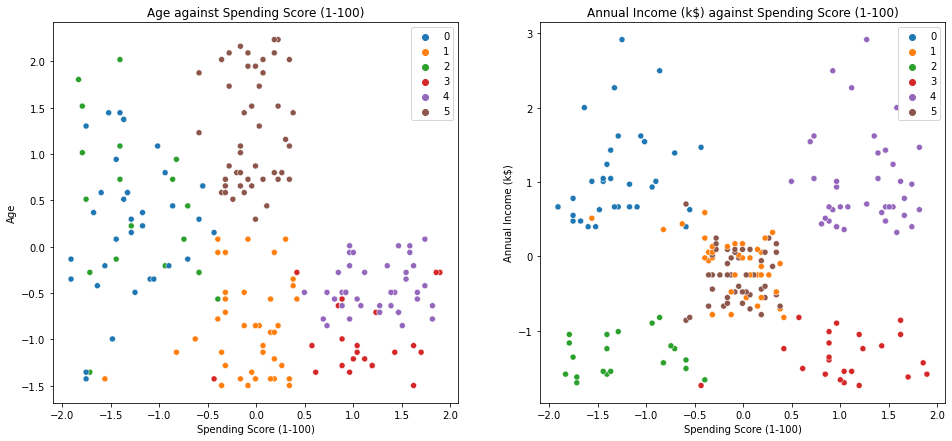

In [22]:
spec_cluster_6 = SpectralClustering(n_clusters=6, assign_labels='discretize',random_state=0).fit(cust_df_scale)

spec_labels = spec_cluster_6.labels_

# Plotting the PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,7))
# Plotting Age against Spending Score (1-100)
sns.scatterplot(x = 'Spending Score (1-100)', y='Age', hue = spec_labels, palette = 'tab10', data = cust_df_scale, ax = ax1)
ax1.set_title("Age against Spending Score (1-100)")

# Plotting Annual Income (k$) against Spending Score (1-100)
sns.scatterplot(x = 'Spending Score (1-100)', y='Annual Income (k$)', hue = spec_labels, palette = 'tab10', data = cust_df_scale, ax = ax2)
ax2.set_title("Annual Income (k$) against Spending Score (1-100)")

plt.show()

The clustering of AgglomerativeClustering and SpectralClustering reviews similar trend to the K-Means clustering but it seems that K-Means is able to seperate the classes better with lesser overlapping points than the rest of algorithm. Hence, we will be using $K-Means, k=6$ for the Final Interpretation.

# Clusters Interpretations
To Interpret the cluster formed, I will be utilising two method of Visualisation and Decision Tree in attempt to explain the 6 distinct cluster formed.

## Clustering Visualisation

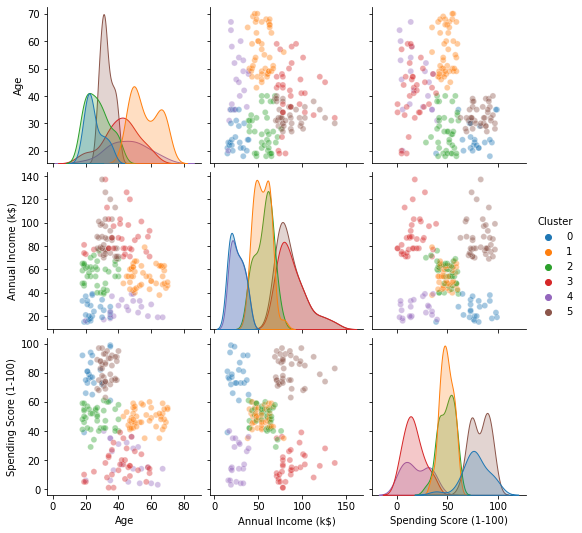

In [23]:
# Use Scaled Dataframe without Gender_Male to Generate Final Clustering
cluster_df = cust_df_scale.copy()

# Generate Final Clustering Labels
_, final_cluster_labels, _, _ = calculate_k_mean(6, cluster_df)

# Inverse Scaling to Review Original Scale for Interpretation
cluster_df[cluster_df.columns] = scaler.inverse_transform(cluster_df) 

cluster_df['Cluster'] = final_cluster_labels

sns.pairplot(cluster_df, hue = 'Cluster', palette = 'tab10', plot_kws=dict(alpha=0.4))
plt.show()

## Surrogate Model : Decision Tree
To better quantify the clustering rule, a Decision Tree can be used as a surrogate model for us to better understand the decision rule by which each cluster is associated.

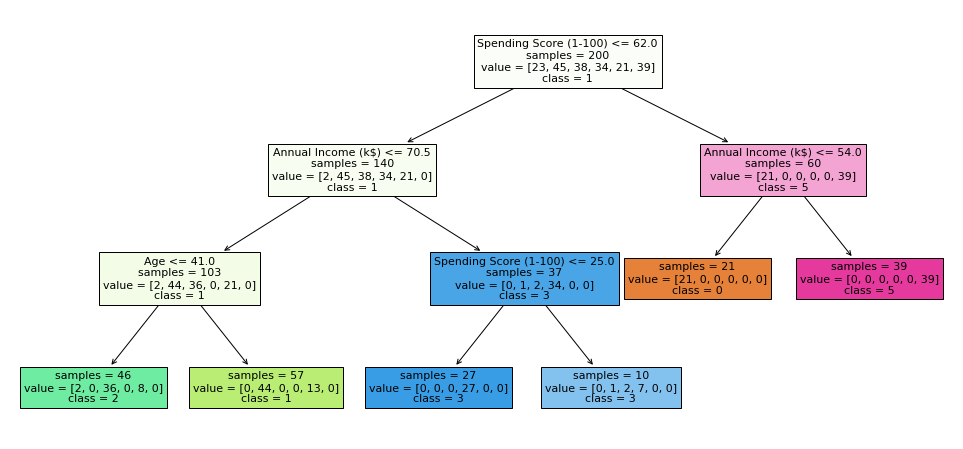

In [24]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

clf.fit(cluster_df.drop(columns='Cluster'), cluster_df['Cluster'])

fig, ax = plt.subplots(figsize = (17,8))
plot_tree(
            clf,
            feature_names = cluster_df.drop(columns='Cluster').columns,
            class_names= np.unique(cluster_df['Cluster'].values.astype(str)),
            impurity=False,
            filled = True, 
            ax = ax, 
            fontsize=11
            )
plt.show()

The following are the interpretation observation for each classes:

0. **Overspending Youngsters** a.k.a. ***"Trendy Ah Beng"***

    Class 0 has a higher tendency to overspends (spend more than they earn) with most of the class members being youngsters that are at most 40 years old.

    > Youngsters that can spend more and earn less are most likely getting their incentives from their parents, and the marketing strategy to devise is probably to sell **items that can resonate with youths** better like sport equipments or idols endorsed products.

1. **Senior Moderate Buyers** a.k.a. ***"Housewife Aunty"***

    Class 1 has a moderate income and spending score which reflected their strong financial awareness which is Highly Similar to Class 2 with Age being the only seperating factors. Besides, Class 1 is also the largest spending group with 45 members provided the sampling is done randomly and unbiased.

    > Being the most loyal customer to the supermarket, strategy like campaigns would not actually make much effects to their spending behaviours. The subtle strategy that could be adopted is through **occasional offerings** like Bundle Sale or Buy 1 Get 1 Free to boost their spending behaviour for staple goods.

2. **Junior Moderate Buyers** a.k.a. ***"Employed Alan"***

    Class 2 also has a moderate income and spending score like Class 1 but with most of its member below age of 41.

    > They are youth who are just starting to work with relative moderate money to spend on groceries. Perhaps some **campaigns or games that allows them to exchange vouchers** or winning lucky draws can inspire them to spend more and earn more points for the campaign.

3. **The Stingy Buyers** a.k.a. ***"Kiamsiap Uncle John"***

    Class 3 spend less on marketing despite earning more. Class 3 also spans across a wider range of age group of between around 20 to 80. This group of customer also make up of a good deal of members of 34 out of the 200 total customer in the dataset.

    > They should be the **main focus of marketing strategy** as they has the **capabilities to spend more than what they are spending now**. Hence, further analysis should be done to study closely their spending behaviours in order to devise more specific strategy like maybe expanding the luxury item section etc.

4. **Low Income Buyers** a.k.a. ***"Needy Jenny"***

    Class 4 belongs to customers from lower income and lower spending group across ages.

    > They are the one that **needs the most help** from the supermarket although it might be a blunt to just directly provide offers and incentives for them, one strategy is to organise campaigns that **allow them exchange staple goods through the green act** of maybe collecting reusable materials or returning plastics bags to boost the companies' image of being environmental aware and to promote supermarket to their peers. 

5. **Young Generous Buyers** a.k.a. ***"Entrepreneur Ben"***

    Class 5 belongs to very special group of youngsters that has higher than average spending and earning capabilities

    > Since this customer group is highly populated by youth, stategy mention in Class 1 like importing items that can **resonate with youths** and expanding the luxurious items sections like wines could catch their attentions.

# Conclusion : The Marketing Strategy
To answer the second objective and based on the clustering interpretation, the mall supermarket should devise the following two strategy to boost the growth and reputation of the supermarket.

## 1. Appealing to the Millennials and Gen-Z

As we have two major customer cluster(Class 0 & Class 5) that is made up of **Millennials(Age 24-40) and Gen-Z(Age 6-24)**, the mall should make sure relevant action is taken to **instill some element resonance** to appeal these two groups of young customer. As millennials are ***experience seeker, eager for self-expression and identity and tech-savvy***,
the following are the approach proposed:
- Online Purchasing Platform with Delivery Service
- Diversify Product Sold to Include Youth-Appealing Items *(e.g. Fashionables, Entertainment Systems and Mobile Devices, Sports Peripherals)*

## 2. Engage the Mature Customer

From Class 1 and Class 3 we noticed a huge proportional of our customer are made up of **mature buyer** be it those with higher spending score or those with moderate spending score. Their **spending behaviour are relatively consistent** and hence the approach taken should not be more subtle and not too drastic to improve their spending behaviour.
The following are the approach proposed:
- Bundle Sales and Rotational Discount
- Coupon Based Campaign/Lucky Draw to encourage Spending and Bulk Purchase by the customer

Reference :
- [Understanding Gen Z, millennial shopping behaviour is key to the future of retail](https://www.straitstimes.com/business/companies-markets/understanding-gen-z-millennial-shopping-behaviour-is-key-to-the-future-of)
- [Segment and Sell to Gen Y: 10 Ways Younger and Older Millennials Shop Differently](https://www.npd.com/news/thought-leadership/2018/10-ways-younger-and-older-millennials-shop-differently/)

# Personal Learning Journey

I do enjoy the entire process of Unsupervised Learning : Clustering as I found it thrilling to **Discover the Hidden Chest** in the dataset. Although I am aware that this example is in an extremely ideal state, it serves as a good example to demonstrate the clustering process. I also appreciate the multidisciplinary nature of data science that allows me to gain more exposure on devising inclusive and viable business strategy for the Mall Supermarket.

Written By : Wong Zhao Wu

Last Modified : 26 July 2020

![Unsplash Fred Meyer Superstore](https://images.unsplash.com/photo-1515706886582-54c73c5eaf41?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=750&q=80)

Image retrieved from [Unsplash](https://unsplash.com/photos/KfvknMhkmw0).